### Neural Networks for Handwritten Digit Recognition, Binary

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

%matplotlib inline

import logging

logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

In [2]:
def load_data():
    X = np.loadtxt("data/X.csv", delimiter=',')
    y = np.loadtxt("data/y.csv", delimiter=',')
    y = y.reshape(-1, 1)
    X = X[0:1000]
    y = y[0:1000]
    return X, y


# def load_weights():
#     w1 = np.load("data/w1.npy")
#     b1 = np.load("data/b1.npy")
#     w2 = np.load("data/w2.npy")
#     b2 = np.load("data/b2.npy")
#     return w1, b1, w2, b2


def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

## Neural Networks

This is a binary classification task.

### Dataset

- The data set contains 1000 training examples of handwritten digits $^1$, here limited to zero and one.  

    - Each training example is a 20-pixel x 20-pixel grayscale image of the digit. 
        - Each pixel is represented by a floating-point number indicating the grayscale intensity at that location. 
        - The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. 
        - Each training example becomes a single row in our data matrix `X`. 
        - This gives us a 1000 x 400 matrix `X` where every row is a training example of a handwritten digit image.

$$X = 
\left(\begin{array}{cc} 
--- (x^{(1)}) --- \\
--- (x^{(2)}) --- \\
\vdots \\ 
--- (x^{(m)}) --- 
\end{array}\right)$$ 

- The second part of the training set is a 1000 x 1 dimensional vector `y` that contains labels for the training set
    - `y = 0` if the image is of the digit `0`, `y = 1` if the image is of the digit `1`.

$^1$<sub> This is a subset of the MNIST handwritten digit dataset (http://yann.lecun.com/exdb/mnist/)</sub>

In [3]:
# load dataset
X, y = load_data()


In [4]:
print("The first element of X is: ", X[0])

The first element of X is:  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+

In [5]:
print("The first element of y is: ", y[0, 0])
print("The last element of y is: ", y[-1, 0])

The first element of y is:  0.0
The last element of y is:  1.0


In [6]:
print("The shape of X is: " + str(X.shape))
print("The shape of y is: " + str(y.shape))

The shape of X is: (1000, 400)
The shape of y is: (1000, 1)


#### Visualizing the Data


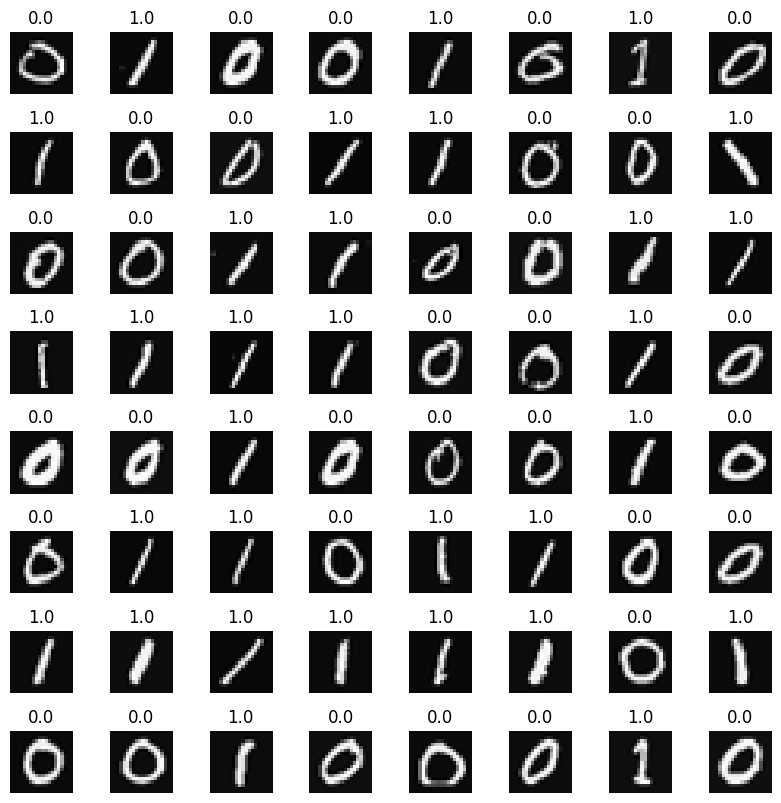

In [7]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

m, n = X.shape

fig, axes = plt.subplots(8, 8, figsize=(8, 8))
fig.tight_layout(pad=0.1)

for i, ax in enumerate(axes.flat):
    random_index = np.random.randint(m)

    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = X[random_index].reshape((20, 20)).T

    # Display the image
    ax.imshow(X_random_reshaped, cmap="gray")

    # Display the label above the image
    ax.set_title(y[random_index, 0])
    ax.set_axis_off()

### Model representation

- This has three dense layers with sigmoid activations.
    - Since the images are of size $20\times20$, this gives us $400$ inputs  
    

- The parameters have dimensions that are sized for a neural network with $25$ units in layer 1, $15$ units in layer 2 and $1$ output unit in layer 3. 

    - The dimensions of these parameters are determined as follows:
        - If network has $s_{in}$ units in a layer and $s_{out}$ units in the next layer, then 
            - $W$ will be of dimension $s_{in} \times s_{out}$.
            - $b$ will a vector with $s_{out}$ elements
  
    - Therefore, the shapes of `W`, and `b`,  are 
        - layer1: The shape of `W1` is (400, 25) and the shape of `b1` is (25,)
        - layer2: The shape of `W2` is (25, 15) and the shape of `b2` is: (15,)
        - layer3: The shape of `W3` is (15, 1) and the shape of `b3` is: (1,)
>**Note:** The bias vector `b` could be represented as a 1-D (n,) or 2-D (n,1) array. Tensorflow utilizes a 1-D representation and this lab will maintain that convention. 
               

### Tensorflow Model Implementation


Tensorflow models are built layer by layer. A layer's input dimensions ($s_{in}$ above) are calculated for you. The layer's *output dimensions* must be specified and this determines the next layer's input dimension. The input dimension of the first layer is derived from the size of the input data specified in the `model.fit` statment below. 

>**Note:** It is also possible to add an input layer that specifies the input dimension of the first layer. For example:  

`tf.keras.Input(shape=(400,)),    #specify input shape`  

In [8]:
model = Sequential(
    [
        tf.keras.Input(shape=(400,)),
        tf.keras.layers.Dense(25, activation="sigmoid"),
        tf.keras.layers.Dense(15, activation="sigmoid"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ],
    name="my_model",
)

In [9]:
model.summary()


Model: "my_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 25)             │        10,025 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │           390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,431 (40.75 KB)

 Trainable params: 10,431 (40.75 KB)

 Non-trainable params: 0 (0.00 B)

The parameter counts shown in the summary correspond to the number of elements in the weight and bias arrays as shown below.

In [10]:
L1_num_params = 400 * 25 + 25  # W1 parameters  + b1 parameters
L2_num_params = 25 * 15 + 15  # W2 parameters  + b2 parameters
L3_num_params = 15 * 1 + 1  # W3 parameters  + b3 parameters
print(
    "L1 params = ",
    L1_num_params,
    ", L2 params = ",
    L2_num_params,
    ",  L3 params = ",
    L3_num_params,
)

L1 params =  10025 , L2 params =  390 ,  L3 params =  16


Let's further examine the weights to verify that tensorflow produced the same dimensions as we calculated above.

In [11]:
[layer1, layer2, layer3] = model.layers


In [12]:
#### Examine Weights shapes
W1, b1 = layer1.get_weights()
W2, b2 = layer2.get_weights()
W3, b3 = layer3.get_weights()
print(f"W1 shape = {W1.shape}, b1 shape = {b1.shape}")
print(f"W2 shape = {W2.shape}, b2 shape = {b2.shape}")
print(f"W3 shape = {W3.shape}, b3 shape = {b3.shape}")

W1 shape = (400, 25), b1 shape = (25,)
W2 shape = (25, 15), b2 shape = (15,)
W3 shape = (15, 1), b3 shape = (1,)


`xx.get_weights` returns a NumPy array. One can also access the weights directly in their tensor form. Note the shape of the tensors in the final layer.

In [13]:
print(model.layers[2].weights)


[<Variable path=my_model/dense_2/kernel, shape=(15, 1), dtype=float32, value=[[ 0.2644127 ]
 [ 0.06860322]
 [-0.15746802]
 [ 0.56209546]
 [-0.385735  ]
 [-0.3672691 ]
 [-0.36612839]
 [ 0.56009823]
 [ 0.49271446]
 [ 0.4746589 ]
 [-0.48790574]
 [-0.40585613]
 [ 0.05078381]
 [-0.15207854]
 [-0.3424396 ]]>, <Variable path=my_model/dense_2/bias, shape=(1,), dtype=float32, value=[0.]>]


In [14]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.001),
)

model.fit(X, y, epochs=20)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - loss: 0.6471 
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4661 
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3146 
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2020 
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1369 
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1025 
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step - loss: 0.0785
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step - loss: 0.0633
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step - loss: 0.0522
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step - loss: 0.0462
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step - loss: 0.0396
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - loss: 0.0330
Epoch 13/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - loss: 0.0305
Epoch 14/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step - loss: 0.0284
Epoch 15/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step - loss: 

In [15]:
prediction = model.predict(X[0].reshape(1, 400))  # a zero
print(f" predicting a zero: {prediction}")
prediction = model.predict(X[500].reshape(1, 400))  # a one
print(f" predicting a one:  {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
 predicting a zero: [[0.01219622]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
 predicting a one:  [[0.98623145]]


The output of the model is interpreted as a probability. In the first example above, the input is a zero. The model predicts the probability that the input is a one is nearly zero. 
In the second example, the input is a one. The model predicts the probability that the input is a one is nearly one.
As in the case of logistic regression, the probability is compared to a threshold to make a final prediction.

In [16]:
if prediction >= 0.5:
    yhat = 1
else:
    yhat = 0
print(f"prediction after threshold: {yhat}")


prediction after threshold: 1


Let's compare the predictions vs the labels for a random sample of 64 digits.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━

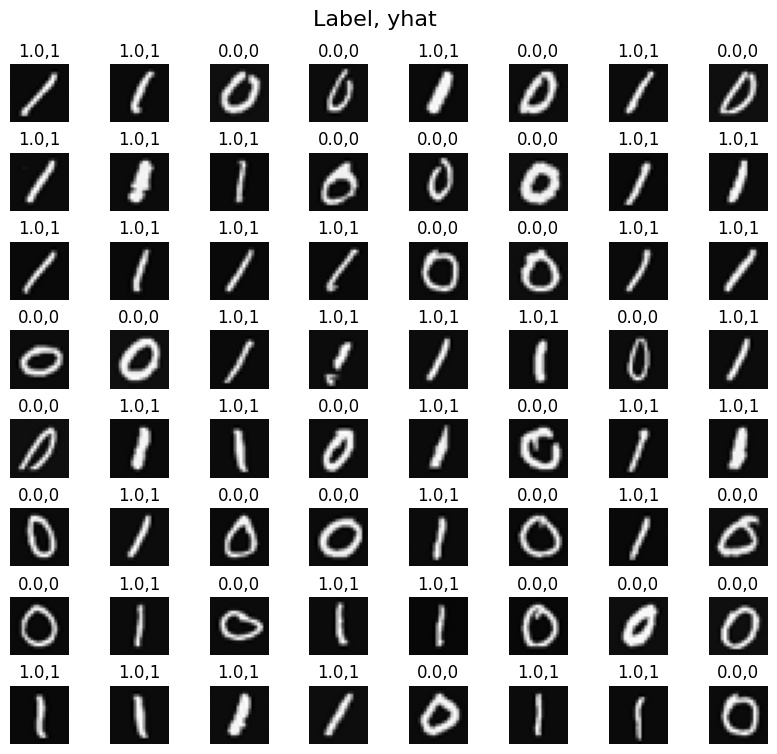

In [17]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

m, n = X.shape

fig, axes = plt.subplots(8, 8, figsize=(8, 8))
fig.tight_layout(pad=0.1, rect=[0, 0.03, 1, 0.92])  # [left, bottom, right, top]

for i, ax in enumerate(axes.flat):
    random_index = np.random.randint(m)

    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = X[random_index].reshape((20, 20)).T

    # Display the image
    ax.imshow(X_random_reshaped, cmap="gray")

    # Predict using the Neural Network
    prediction = model.predict(X[random_index].reshape(1, 400))
    if prediction >= 0.5:
        yhat = 1
    else:
        yhat = 0

    # Display the label above the image
    ax.set_title(f"{y[random_index,0]},{yhat}")
    ax.set_axis_off()
fig.suptitle("Label, yhat", fontsize=16)
plt.show()

In [18]:
def my_dense(a_in, W, b, g):
    """
    Computes dense layer
    Args:
      a_in: Data, 1 example
      W: Weight matrix, n features per unit, j units
      b: bias vector, j units
      g: activation function (e.g. sigmoid, relu..)
    Returns
      a_out: j units
    """
    units = W.shape[1]
    a_out = np.zeros(units)
    for i in range(units):
        w = W[:, i]
        z = np.dot(w, a_in) + b[i]
        a_out[i] = g(z)
    return a_out

In [19]:
# Quick Check
x_tst = 0.1 * np.arange(1, 3, 1).reshape(
    2,
)  # (1 examples, 2 features)
W_tst = 0.1 * np.arange(1, 7, 1).reshape(2, 3)  # (2 input features, 3 output features)
b_tst = 0.1 * np.arange(1, 4, 1).reshape(
    3,
)  # (3 features)
A_tst = my_dense(x_tst, W_tst, b_tst, sigmoid)
print(A_tst)

[0.54735762 0.57932425 0.61063923]


The following cell builds a three-layer neural network utilizing the `my_dense` subroutine above.

In [20]:
def my_sequential(x, W1, b1, W2, b2, W3, b3):
    a1 = my_dense(x, W1, b1, sigmoid)
    a2 = my_dense(a1, W2, b2, sigmoid)
    a3 = my_dense(a2, W3, b3, sigmoid)
    return a3

We can copy trained weights and biases from Tensorflow.

In [21]:
W1_tmp, b1_tmp = layer1.get_weights()
W2_tmp, b2_tmp = layer2.get_weights()
W3_tmp, b3_tmp = layer3.get_weights()

In [22]:
# make predictions
prediction = my_sequential(X[0], W1_tmp, b1_tmp, W2_tmp, b2_tmp, W3_tmp, b3_tmp)
if prediction >= 0.5:
    yhat = 1
else:
    yhat = 0
print("yhat = ", yhat, " label= ", y[0, 0])
prediction = my_sequential(X[500], W1_tmp, b1_tmp, W2_tmp, b2_tmp, W3_tmp, b3_tmp)
if prediction >= 0.5:
    yhat = 1
else:
    yhat = 0
print("yhat = ", yhat, " label= ", y[500, 0])

yhat =  0  label=  0.0
yhat =  1  label=  1.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/var/folders/63/j6w_zsv155n1r5q96vf1qrwc0000gn/T/ipykernel_65408/1653845393.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  my_yhat = int(my_prediction >= 0.5)
/var/folders/63/j6w_zsv155n1r5q96vf1qrwc0000gn/T/ipykernel_65408/1653845393.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  tf_yhat = int(tf_prediction >= 0.5)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━

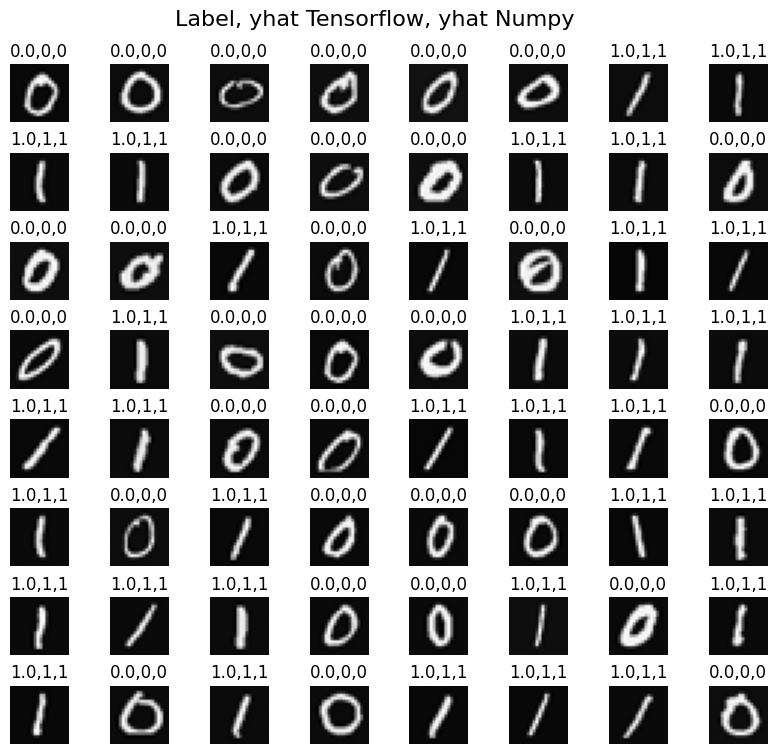

In [23]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

m, n = X.shape

fig, axes = plt.subplots(8, 8, figsize=(8, 8))
fig.tight_layout(pad=0.1, rect=[0, 0.03, 1, 0.92])  # [left, bottom, right, top]

for i, ax in enumerate(axes.flat):
    random_index = np.random.randint(m)

    X_random_reshaped = X[random_index].reshape((20, 20)).T
    ax.imshow(X_random_reshaped, cmap="gray")
    my_prediction = my_sequential(
        X[random_index], W1_tmp, b1_tmp, W2_tmp, b2_tmp, W3_tmp, b3_tmp
    )
    my_yhat = int(my_prediction >= 0.5)
    tf_prediction = model.predict(X[random_index].reshape(1, 400))
    tf_yhat = int(tf_prediction >= 0.5)
    ax.set_title(f"{y[random_index,0]},{tf_yhat},{my_yhat}")
    ax.set_axis_off()
fig.suptitle("Label, yhat Tensorflow, yhat Numpy", fontsize=16)
plt.show()

### Vectorized NumPy Model Implementation

In [24]:
x = X[0].reshape(-1, 1)  # column vector (400,1)
z1 = np.matmul(x.T, W1) + b1  # (1,400)(400,25) = (1,25)
a1 = sigmoid(z1)
print(a1.shape)

(1, 25)


In [25]:
def my_dense_v(A_in, W, b, g):
    """
    Computes dense layer
    Args:
      A_in: Data, m examples, n features each
      W: Weight matrix, n features per unit, j units
      b: bias vector, j units
      g: activation function (e.g. sigmoid, relu..)
    Returns
      A_out: m examples, j units
    """
    A_out = g(np.matmul(A_in, W) + b)
    return A_out

In [26]:
X_tst = 0.1 * np.arange(1, 9, 1).reshape(4, 2)  # (4 examples, 2 features)
W_tst = 0.1 * np.arange(1, 7, 1).reshape(2, 3)  # (2 input features, 3 output features)
b_tst = 0.1 * np.arange(1, 4, 1).reshape(1, 3)  # (1, 3 features)
A_tst = my_dense_v(X_tst, W_tst, b_tst, sigmoid)
print(A_tst)

[[0.54735762 0.57932425 0.61063923]
 [0.57199613 0.61301418 0.65248946]
 [0.5962827  0.64565631 0.6921095 ]
 [0.62010643 0.67699586 0.72908792]]


The following cell builds a three-layer neural network utilizing the `my_dense_v` subroutine above.

In [27]:
def my_sequential_v(X, W1, b1, W2, b2, W3, b3):
    A1 = my_dense_v(X, W1, b1, sigmoid)
    A2 = my_dense_v(A1, W2, b2, sigmoid)
    A3 = my_dense_v(A2, W3, b3, sigmoid)
    return A3

We can again copy trained weights and biases from Tensorflow.

In [28]:
W1_tmp, b1_tmp = layer1.get_weights()
W2_tmp, b2_tmp = layer2.get_weights()
W3_tmp, b3_tmp = layer3.get_weights()

In [29]:
Prediction = my_sequential_v(X, W1_tmp, b1_tmp, W2_tmp, b2_tmp, W3_tmp, b3_tmp)
Prediction.shape

(1000, 1)

We'll apply a threshold of 0.5 as before, but to all predictions at once.

In [30]:
Yhat = (Prediction >= 0.5).astype(int)
print("predict a zero: ", Yhat[0], "predict a one: ", Yhat[500])

predict a zero:  [0] predict a one:  [1]


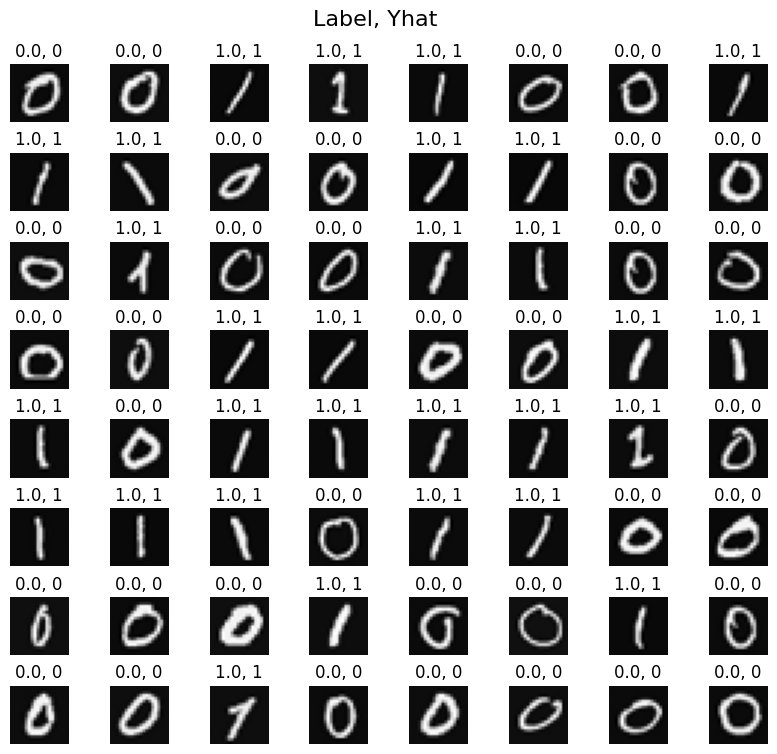

In [31]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

m, n = X.shape

fig, axes = plt.subplots(8, 8, figsize=(8, 8))
fig.tight_layout(pad=0.1, rect=[0, 0.03, 1, 0.92])  # [left, bottom, right, top]

for i, ax in enumerate(axes.flat):
    random_index = np.random.randint(m)
    X_random_reshaped = X[random_index].reshape((20, 20)).T
    ax.imshow(X_random_reshaped, cmap="gray")
    ax.set_title(f"{y[random_index,0]}, {Yhat[random_index, 0]}")
    ax.set_axis_off()
fig.suptitle("Label, Yhat", fontsize=16)
plt.show()

You can see how one of the misclassified images looks.

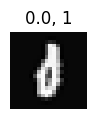

In [32]:
fig = plt.figure(figsize=(1, 1))
errors = np.where(y != Yhat)
random_index = errors[0][0]
X_random_reshaped = X[random_index].reshape((20, 20)).T
plt.imshow(X_random_reshaped, cmap="gray")
plt.title(f"{y[random_index,0]}, {Yhat[random_index, 0]}")
plt.axis("off")
plt.show()